In [6]:
from datetime import datetime
import os
import sys
import time
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

import argparse
import os
import tensorflow as tf
from utils import ImageReader, decode_labels, inv_preprocess, prepare_label, write_log, read_labeled_image_list


ModuleNotFoundError: No module named 'utils'

In [ ]:









IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)

class Model(object):

	def __init__(self, sess, conf):
		self.sess = sess
		self.conf = conf

	# train
	def train(self):
		self.train_setup()

		self.sess.run(tf.global_variables_initializer())

		# Load the pre-trained model if provided
		if self.conf.pretrain_file is not None:
			self.load(self.loader, self.conf.pretrain_file)

		# Start queue threads.
		threads = tf.train.start_queue_runners(coord=self.coord, sess=self.sess)

		# Train!
		for step in range(self.conf.num_steps+1):
			start_time = time.time()
			feed_dict = { self.curr_step : step }

			if step % self.conf.save_interval == 0:
				loss_value, images, labels, preds, summary, _ = self.sess.run(
					[self.reduced_loss,
					self.image_batch,
					self.label_batch,
					self.pred,
					self.total_summary,
					self.train_op],
					feed_dict=feed_dict)
				self.summary_writer.add_summary(summary, step)
				self.save(self.saver, step)
			else:
				loss_value, _ = self.sess.run([self.reduced_loss, self.train_op],
					feed_dict=feed_dict)

			duration = time.time() - start_time
			print('step {:d} \t loss = {:.3f}, ({:.3f} sec/step)'.format(step, loss_value, duration))
			write_log('{:d}, {:.3f}'.format(step, loss_value), self.conf.logfile)

		# finish
		self.coord.request_stop()
		self.coord.join(threads)

	# evaluate
	def test(self):
		self.test_setup()

		self.sess.run(tf.global_variables_initializer())
		self.sess.run(tf.local_variables_initializer())

		# load checkpoint
		checkpointfile = self.conf.modeldir+ '/model.ckpt-' + str(self.conf.valid_step)
		self.load(self.loader, checkpointfile)

		# Start queue threads.
		threads = tf.train.start_queue_runners(coord=self.coord, sess=self.sess)

		# Test!
		confusion_matrix = np.zeros((self.conf.num_classes, self.conf.num_classes), dtype=np.int)
		for step in range(self.conf.valid_num_steps):
			preds, _, _, c_matrix = self.sess.run([self.pred, self.accu_update_op, self.mIou_update_op, self.confusion_matrix])
			confusion_matrix += c_matrix
			if step % 100 == 0:
				print('step {:d}'.format(step))
		print('Pixel Accuracy: {:.3f}'.format(self.accu.eval(session=self.sess)))
		print('Mean IoU: {:.3f}'.format(self.mIoU.eval(session=self.sess)))
		self.compute_IoU_per_class(confusion_matrix)

		# finish
		self.coord.request_stop()
		self.coord.join(threads)

	# prediction
	def predict(self):
		self.predict_setup()

		self.sess.run(tf.global_variables_initializer())
		self.sess.run(tf.local_variables_initializer())

		# load checkpoint
		checkpointfile = self.conf.modeldir+ '/model.ckpt-' + str(self.conf.valid_step)
		self.load(self.loader, checkpointfile)

		# Start queue threads.
		threads = tf.train.start_queue_runners(coord=self.coord, sess=self.sess)

		# img_name_list
		image_list, _ = read_labeled_image_list('', self.conf.test_data_list)

		# Predict!
		for step in range(self.conf.test_num_steps):
			preds = self.sess.run(self.pred)

			img_name = image_list[step].split('/')[2].split('.')[0]
			# Save raw predictions, i.e. each pixel is an integer between [0,20].
			im = Image.fromarray(preds[0,:,:,0], mode='L')
			filename = '/%s_mask.png' % (img_name)
			im.save(self.conf.out_dir + '/prediction' + filename)

			# Save predictions for visualization.
			# See utils/label_utils.py for color setting
			# Need to be modified based on datasets.
			if self.conf.visual:
				msk = decode_labels(preds, num_classes=self.conf.num_classes)
				im = Image.fromarray(msk[0], mode='RGB')
				filename = '/%s_mask_visual.png' % (img_name)
				im.save(self.conf.out_dir + '/visual_prediction' + filename)

			if step % 100 == 0:
				print('step {:d}'.format(step))

		print('The output files has been saved to {}'.format(self.conf.out_dir))

		# finish
		self.coord.request_stop()
		self.coord.join(threads)

	def train_setup(self):
		tf.set_random_seed(self.conf.random_seed)
		
		# Create queue coordinator.
		self.coord = tf.train.Coordinator()

		# Input size
		input_size = (self.conf.input_height, self.conf.input_width)
		
		# Load reader
		with tf.name_scope("create_inputs"):
			reader = ImageReader(
				self.conf.data_dir,
				self.conf.data_list,
				input_size,
				self.conf.random_scale,
				self.conf.random_mirror,
				self.conf.ignore_label,
				IMG_MEAN,
				self.coord)
			self.image_batch, self.label_batch = reader.dequeue(self.conf.batch_size)
		
		# Create network
		if self.conf.encoder_name not in ['res101', 'res50', 'deeplab']:
			print('encoder_name ERROR!')
			print("Please input: res101, res50, or deeplab")
			sys.exit(-1)
		elif self.conf.encoder_name == 'deeplab':
			net = Deeplab_v2(self.image_batch, self.conf.num_classes, True)
			# Variables that load from pre-trained model.
			restore_var = [v for v in tf.global_variables() if 'fc' not in v.name]
			# Trainable Variables
			all_trainable = tf.trainable_variables()
			# Fine-tune part
			encoder_trainable = [v for v in all_trainable if 'fc' not in v.name] # lr * 1.0
			# Decoder part
			decoder_trainable = [v for v in all_trainable if 'fc' in v.name]
		else:
			net = ResNet_segmentation(self.image_batch, self.conf.num_classes, True, self.conf.encoder_name)
			# Variables that load from pre-trained model.
			restore_var = [v for v in tf.global_variables() if 'resnet_v1' in v.name]
			# Trainable Variables
			all_trainable = tf.trainable_variables()
			# Fine-tune part
			encoder_trainable = [v for v in all_trainable if 'resnet_v1' in v.name] # lr * 1.0
			# Decoder part
			decoder_trainable = [v for v in all_trainable if 'decoder' in v.name]
		
		decoder_w_trainable = [v for v in decoder_trainable if 'weights' in v.name or 'gamma' in v.name] # lr * 10.0
		decoder_b_trainable = [v for v in decoder_trainable if 'biases' in v.name or 'beta' in v.name] # lr * 20.0
		# Check
		assert(len(all_trainable) == len(decoder_trainable) + len(encoder_trainable))
		assert(len(decoder_trainable) == len(decoder_w_trainable) + len(decoder_b_trainable))

		# Network raw output
		raw_output = net.outputs # [batch_size, h, w, 21]

		# Output size
		output_shape = tf.shape(raw_output)
		output_size = (output_shape[1], output_shape[2])

		# Groud Truth: ignoring all labels greater or equal than n_classes
		label_proc = prepare_label(self.label_batch, output_size, num_classes=self.conf.num_classes, one_hot=False)
		raw_gt = tf.reshape(label_proc, [-1,])
		indices = tf.squeeze(tf.where(tf.less_equal(raw_gt, self.conf.num_classes - 1)), 1)
		gt = tf.cast(tf.gather(raw_gt, indices), tf.int32)
		raw_prediction = tf.reshape(raw_output, [-1, self.conf.num_classes])
		prediction = tf.gather(raw_prediction, indices)

		# Pixel-wise softmax_cross_entropy loss
		loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, labels=gt)
		# L2 regularization
		l2_losses = [self.conf.weight_decay * tf.nn.l2_loss(v) for v in all_trainable if 'weights' in v.name]
		# Loss function
		self.reduced_loss = tf.reduce_mean(loss) + tf.add_n(l2_losses)

		# Define optimizers
		# 'poly' learning rate
		base_lr = tf.constant(self.conf.learning_rate)
		self.curr_step = tf.placeholder(dtype=tf.float32, shape=())
		learning_rate = tf.scalar_mul(base_lr, tf.pow((1 - self.curr_step / self.conf.num_steps), self.conf.power))
		# We have several optimizers here in order to handle the different lr_mult
		# which is a kind of parameters in Caffe. This controls the actual lr for each
		# layer.
		opt_encoder = tf.train.MomentumOptimizer(learning_rate, self.conf.momentum)
		opt_decoder_w = tf.train.MomentumOptimizer(learning_rate * 10.0, self.conf.momentum)
		opt_decoder_b = tf.train.MomentumOptimizer(learning_rate * 20.0, self.conf.momentum)
		# To make sure each layer gets updated by different lr's, we do not use 'minimize' here.
		# Instead, we separate the steps compute_grads+update_params.
		# Compute grads
		grads = tf.gradients(self.reduced_loss, encoder_trainable + decoder_w_trainable + decoder_b_trainable)
		grads_encoder = grads[:len(encoder_trainable)]
		grads_decoder_w = grads[len(encoder_trainable) : (len(encoder_trainable) + len(decoder_w_trainable))]
		grads_decoder_b = grads[(len(encoder_trainable) + len(decoder_w_trainable)):]
		# Update params
		train_op_conv = opt_encoder.apply_gradients(zip(grads_encoder, encoder_trainable))
		train_op_fc_w = opt_decoder_w.apply_gradients(zip(grads_decoder_w, decoder_w_trainable))
		train_op_fc_b = opt_decoder_b.apply_gradients(zip(grads_decoder_b, decoder_b_trainable))
		# Finally, get the train_op!
		update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # for collecting moving_mean and moving_variance
		with tf.control_dependencies(update_ops):
			self.train_op = tf.group(train_op_conv, train_op_fc_w, train_op_fc_b)

		# Saver for storing checkpoints of the model
		self.saver = tf.train.Saver(var_list=tf.global_variables(), max_to_keep=0)

		# Loader for loading the pre-trained model
		
		self.loader = tf.train.Saver(var_list=restore_var)

		# Training summary
		# Processed predictions: for visualisation.
		raw_output_up = tf.image.resize_bilinear(raw_output, input_size)
		raw_output_up = tf.argmax(raw_output_up, axis=3)
		self.pred = tf.expand_dims(raw_output_up, dim=3)
		# Image summary.
		images_summary = tf.py_func(inv_preprocess, [self.image_batch, 2, IMG_MEAN], tf.uint8)
		labels_summary = tf.py_func(decode_labels, [self.label_batch, 2, self.conf.num_classes], tf.uint8)
		preds_summary = tf.py_func(decode_labels, [self.pred, 2, self.conf.num_classes], tf.uint8)
		self.total_summary = tf.summary.image('images',
			tf.concat(axis=2, values=[images_summary, labels_summary, preds_summary]),
			max_outputs=2) # Concatenate row-wise.
		if not os.path.exists(self.conf.logdir):
			os.makedirs(self.conf.logdir)
		self.summary_writer = tf.summary.FileWriter(self.conf.logdir, graph=tf.get_default_graph())

	def test_setup(self):
		# Create queue coordinator.
		self.coord = tf.train.Coordinator()

		# Load reader
		with tf.name_scope("create_inputs"):
			reader = ImageReader(
				self.conf.data_dir,
				self.conf.valid_data_list,
				None, # the images have different sizes
				False, # no data-aug
				False, # no data-aug
				self.conf.ignore_label,
				IMG_MEAN,
				self.coord)
			image, label = reader.image, reader.label # [h, w, 3 or 1]
		# Add one batch dimension [1, h, w, 3 or 1]
		self.image_batch, self.label_batch = tf.expand_dims(image, dim=0), tf.expand_dims(label, dim=0)
		
		# Create network
		if self.conf.encoder_name not in ['res101', 'res50', 'deeplab']:
			print('encoder_name ERROR!')
			print("Please input: res101, res50, or deeplab")
			sys.exit(-1)
		elif self.conf.encoder_name == 'deeplab':
			net = Deeplab_v2(self.image_batch, self.conf.num_classes, False)
		else:
			net = ResNet_segmentation(self.image_batch, self.conf.num_classes, False, self.conf.encoder_name)

		# predictions
		raw_output = net.outputs
		raw_output = tf.image.resize_bilinear(raw_output, tf.shape(self.image_batch)[1:3,])
		raw_output = tf.argmax(raw_output, axis=3)
		pred = tf.expand_dims(raw_output, dim=3)
		self.pred = tf.reshape(pred, [-1,])
		# labels
		gt = tf.reshape(self.label_batch, [-1,])
		# Ignoring all labels greater than or equal to n_classes.
		temp = tf.less_equal(gt, self.conf.num_classes - 1)
		weights = tf.cast(temp, tf.int32)

		# fix for tf 1.3.0
		gt = tf.where(temp, gt, tf.cast(temp, tf.uint8))

		# Pixel accuracy
		self.accu, self.accu_update_op = tf.contrib.metrics.streaming_accuracy(
			self.pred, gt, weights=weights)

		# mIoU
		self.mIoU, self.mIou_update_op = tf.contrib.metrics.streaming_mean_iou(
			self.pred, gt, num_classes=self.conf.num_classes, weights=weights)

		# confusion matrix
		self.confusion_matrix = tf.contrib.metrics.confusion_matrix(
			self.pred, gt, num_classes=self.conf.num_classes, weights=weights)

		# Loader for loading the checkpoint
		self.loader = tf.train.Saver(var_list=tf.global_variables())

	def predict_setup(self):
		# Create queue coordinator.
		self.coord = tf.train.Coordinator()

		# Load reader
		with tf.name_scope("create_inputs"):
			reader = ImageReader(
				self.conf.data_dir,
				self.conf.test_data_list,
				None, # the images have different sizes
				False, # no data-aug
				False, # no data-aug
				self.conf.ignore_label,
				IMG_MEAN,
				self.coord)
			image, label = reader.image, reader.label # [h, w, 3 or 1]
		# Add one batch dimension [1, h, w, 3 or 1]
		image_batch, label_batch = tf.expand_dims(image, dim=0), tf.expand_dims(label, dim=0)

		# Create network
		if self.conf.encoder_name not in ['res101', 'res50', 'deeplab']:
			print('encoder_name ERROR!')
			print("Please input: res101, res50, or deeplab")
			sys.exit(-1)
		elif self.conf.encoder_name == 'deeplab':
			net = Deeplab_v2(image_batch, self.conf.num_classes, False)
		else:
			net = ResNet_segmentation(image_batch, self.conf.num_classes, False, self.conf.encoder_name)

		# Predictions.
		raw_output = net.outputs
		raw_output = tf.image.resize_bilinear(raw_output, tf.shape(image_batch)[1:3,])
		raw_output = tf.argmax(raw_output, axis=3)
		self.pred = tf.cast(tf.expand_dims(raw_output, dim=3), tf.uint8)

		# Create directory
		if not os.path.exists(self.conf.out_dir):
			os.makedirs(self.conf.out_dir)
			os.makedirs(self.conf.out_dir + '/prediction')
			if self.conf.visual:
				os.makedirs(self.conf.out_dir + '/visual_prediction')

		# Loader for loading the checkpoint
		self.loader = tf.train.Saver(var_list=tf.global_variables())

	def save(self, saver, step):
		'''
		Save weights.
		'''
		model_name = 'model.ckpt'
		checkpoint_path = os.path.join(self.conf.modeldir, model_name)
		if not os.path.exists(self.conf.modeldir):
			os.makedirs(self.conf.modeldir)
		saver.save(self.sess, checkpoint_path, global_step=step)
		print('The checkpoint has been created.')

	def load(self, saver, filename):
		'''
		Load trained weights.
		''' 
		saver.restore(self.sess, filename)
		print("Restored model parameters from {}".format(filename))

	def compute_IoU_per_class(self, confusion_matrix):
		mIoU = 0
		for i in range(self.conf.num_classes):
			# IoU = true_positive / (true_positive + false_positive + false_negative)
			TP = confusion_matrix[i,i]
			FP = np.sum(confusion_matrix[:, i]) - TP
			FN = np.sum(confusion_matrix[i]) - TP
			IoU = TP / (TP + FP + FN)
			print ('class %d: %.3f' % (i, IoU))
			mIoU += IoU / self.conf.num_classes
		print ('mIoU: %.3f' % mIoU)




def configure():
	flags = tf.app.flags

	# training
	flags.DEFINE_integer('num_steps', 20000, 'maximum number of iterations')
	flags.DEFINE_integer('save_interval', 1000, 'number of iterations for saving and visualization')
	flags.DEFINE_integer('random_seed', 1234, 'random seed')
	flags.DEFINE_float('weight_decay', 0.0005, 'weight decay rate')
	flags.DEFINE_float('learning_rate', 2.5e-4, 'learning rate')
	flags.DEFINE_float('power', 0.9, 'hyperparameter for poly learning rate')
	flags.DEFINE_float('momentum', 0.9, 'momentum')
	flags.DEFINE_string('encoder_name', 'deeplab', 'name of pre-trained model, res101, res50 or deeplab')
	flags.DEFINE_string('pretrain_file', './deeplab_resnet_init.ckpt', 'pre-trained model filename corresponding to encoder_name')
	flags.DEFINE_string('data_list', './dataset/train.txt', 'training data list filename')

	# validation
	flags.DEFINE_integer('valid_step', 2000, 'checkpoint number for validation')
	flags.DEFINE_integer('valid_num_steps', 1449, '= number of validation samples')
	flags.DEFINE_string('valid_data_list', './dataset/val.txt', 'validation data list filename')

	# prediction / saving outputs for testing or validation
	flags.DEFINE_string('out_dir', 'output', 'directory for saving outputs')
	flags.DEFINE_integer('test_step', 20000, 'checkpoint number for testing/validation')
	flags.DEFINE_integer('test_num_steps', 1449, '= number of testing/validation samples')
	flags.DEFINE_string('test_data_list', './dataset/val.txt', 'testing/validation data list filename')
	flags.DEFINE_boolean('visual', True, 'whether to save predictions for visualization')

	# data
	flags.DEFINE_string('data_dir', '.', 'data directory')
	flags.DEFINE_integer('batch_size', 5, 'training batch size')
	flags.DEFINE_integer('input_height', 321, 'input image height')
	flags.DEFINE_integer('input_width', 321, 'input image width')
	flags.DEFINE_integer('num_classes', 21, 'number of classes')
	flags.DEFINE_integer('ignore_label', 255, 'label pixel value that should be ignored')
	flags.DEFINE_boolean('random_scale', True, 'whether to perform random scaling data-augmentation')
	flags.DEFINE_boolean('random_mirror', True, 'whether to perform random left-right flipping data-augmentation')
	
	# log
	flags.DEFINE_string('modeldir', 'model', 'model directory')
	flags.DEFINE_string('logfile', 'log.txt', 'training log filename')
	flags.DEFINE_string('logdir', 'log', 'training log directory')
	
	flags.FLAGS.__dict__['__parsed'] = False
	return flags.FLAGS
class ResNet_segmentation(object):
	"""
	Original ResNet-101 ('resnet_v1_101.ckpt')
	Original ResNet-50 ('resnet_v1_50.ckpt')
	"""
	def __init__(self, inputs, num_classes, phase, encoder_name):
		if encoder_name not in ['res101', 'res50']:
			print('encoder_name ERROR!')
			print("Please input: res101, res50")
			sys.exit(-1)
		self.encoder_name = encoder_name
		self.inputs = inputs
		self.num_classes = num_classes
		self.channel_axis = 3
		self.phase = phase # train (True) or test (False), for BN layers in the decoder
		self.build_network()

	def build_network(self):
		self.encoding = self.build_encoder()
		self.outputs = self.build_decoder(self.encoding)

	def build_encoder(self):
		print("-----------build encoder: %s-----------" % self.encoder_name)
		scope_name = 'resnet_v1_101' if self.encoder_name == 'res101' else 'resnet_v1_50'
		with tf.variable_scope(scope_name) as scope:
			outputs = self._start_block('conv1')
			print("after start block:", outputs.shape)
			with tf.variable_scope('block1') as scope:
				outputs = self._bottleneck_resblock(outputs, 256, 'unit_1',	identity_connection=False)
				outputs = self._bottleneck_resblock(outputs, 256, 'unit_2')
				outputs = self._bottleneck_resblock(outputs, 256, 'unit_3')
				print("after block1:", outputs.shape)
			with tf.variable_scope('block2') as scope:
				outputs = self._bottleneck_resblock(outputs, 512, 'unit_1',	half_size=True, identity_connection=False)
				for i in six.moves.range(2, 5):
					outputs = self._bottleneck_resblock(outputs, 512, 'unit_%d' % i)
				print("after block2:", outputs.shape)
			with tf.variable_scope('block3') as scope:
				outputs = self._dilated_bottle_resblock(outputs, 1024, 2, 'unit_1',	identity_connection=False)
				num_layers_block3 = 23 if self.encoder_name == 'res101' else 6
				for i in six.moves.range(2, num_layers_block3+1):
					outputs = self._dilated_bottle_resblock(outputs, 1024, 2, 'unit_%d' % i)
				print("after block3:", outputs.shape)
			with tf.variable_scope('block4') as scope:
				outputs = self._dilated_bottle_resblock(outputs, 2048, 4, 'unit_1', identity_connection=False)
				outputs = self._dilated_bottle_resblock(outputs, 2048, 4, 'unit_2')
				outputs = self._dilated_bottle_resblock(outputs, 2048, 4, 'unit_3')
				print("after block4:", outputs.shape)
				return outputs

	def build_decoder(self, encoding):
		print("-----------build decoder-----------")
		with tf.variable_scope('decoder') as scope:
			outputs = self._ASPP(encoding, self.num_classes, [6, 12, 18, 24])
			print("after aspp block:", outputs.shape)
			return outputs

	# blocks
	def _start_block(self, name):
		outputs = self._conv2d(self.inputs, 7, 64, 2, name=name)
		outputs = self._batch_norm(outputs, name=name, is_training=False, activation_fn=tf.nn.relu)
		outputs = self._max_pool2d(outputs, 3, 2, name='pool1')
		return outputs

	def _bottleneck_resblock(self, x, num_o, name, half_size=False, identity_connection=True):
		first_s = 2 if half_size else 1
		assert num_o % 4 == 0, 'Bottleneck number of output ERROR!'
		# branch1
		if not identity_connection:
			o_b1 = self._conv2d(x, 1, num_o, first_s, name='%s/bottleneck_v1/shortcut' % name)
			o_b1 = self._batch_norm(o_b1, name='%s/bottleneck_v1/shortcut' % name, is_training=False, activation_fn=None)
		else:
			o_b1 = x
		# branch2
		o_b2a = self._conv2d(x, 1, num_o / 4, first_s, name='%s/bottleneck_v1/conv1' % name)
		o_b2a = self._batch_norm(o_b2a, name='%s/bottleneck_v1/conv1' % name, is_training=False, activation_fn=tf.nn.relu)

		o_b2b = self._conv2d(o_b2a, 3, num_o / 4, 1, name='%s/bottleneck_v1/conv2' % name)
		o_b2b = self._batch_norm(o_b2b, name='%s/bottleneck_v1/conv2' % name, is_training=False, activation_fn=tf.nn.relu)

		o_b2c = self._conv2d(o_b2b, 1, num_o, 1, name='%s/bottleneck_v1/conv3' % name)
		o_b2c = self._batch_norm(o_b2c, name='%s/bottleneck_v1/conv3' % name, is_training=False, activation_fn=None)
		# add
		outputs = self._add([o_b1,o_b2c], name='%s/bottleneck_v1/add' % name)
		# relu
		outputs = self._relu(outputs, name='%s/bottleneck_v1/relu' % name)
		return outputs

	def _dilated_bottle_resblock(self, x, num_o, dilation_factor, name, identity_connection=True):
		assert num_o % 4 == 0, 'Bottleneck number of output ERROR!'
		# branch1
		if not identity_connection:
			o_b1 = self._conv2d(x, 1, num_o, 1, name='%s/bottleneck_v1/shortcut' % name)
			o_b1 = self._batch_norm(o_b1, name='%s/bottleneck_v1/shortcut' % name, is_training=False, activation_fn=None)
		else:
			o_b1 = x
		# branch2
		o_b2a = self._conv2d(x, 1, num_o / 4, 1, name='%s/bottleneck_v1/conv1' % name)
		o_b2a = self._batch_norm(o_b2a, name='%s/bottleneck_v1/conv1' % name, is_training=False, activation_fn=tf.nn.relu)

		o_b2b = self._dilated_conv2d(o_b2a, 3, num_o / 4, dilation_factor, name='%s/bottleneck_v1/conv2' % name)
		o_b2b = self._batch_norm(o_b2b, name='%s/bottleneck_v1/conv2' % name, is_training=False, activation_fn=tf.nn.relu)

		o_b2c = self._conv2d(o_b2b, 1, num_o, 1, name='%s/bottleneck_v1/conv3' % name)
		o_b2c = self._batch_norm(o_b2c, name='%s/bottleneck_v1/conv3' % name, is_training=False, activation_fn=None)
		# add
		outputs = self._add([o_b1,o_b2c], name='%s/bottleneck_v1/add' % name)
		# relu
		outputs = self._relu(outputs, name='%s/bottleneck_v1/relu' % name)
		return outputs

	def _ASPP(self, x, num_o, dilations):
		o = []
		for i, d in enumerate(dilations):
			o.append(self._dilated_conv2d(x, 3, num_o, d, name='aspp/conv%d' % (i+1), biased=True))
		return self._add(o, name='aspp/add')

	# layers
	def _conv2d(self, x, kernel_size, num_o, stride, name, biased=False):
		"""
		Conv2d without BN or relu.
		"""
		num_x = x.shape[self.channel_axis].value
		with tf.variable_scope(name) as scope:
			w = tf.get_variable('weights', shape=[kernel_size, kernel_size, num_x, num_o])
			s = [1, stride, stride, 1]
			o = tf.nn.conv2d(x, w, s, padding='SAME')
			if biased:
				b = tf.get_variable('biases', shape=[num_o])
				o = tf.nn.bias_add(o, b)
			return o

	def _dilated_conv2d(self, x, kernel_size, num_o, dilation_factor, name, biased=False):
		"""
		Dilated conv2d without BN or relu.
		"""
		num_x = x.shape[self.channel_axis].value
		with tf.variable_scope(name) as scope:
			w = tf.get_variable('weights', shape=[kernel_size, kernel_size, num_x, num_o])
			o = tf.nn.atrous_conv2d(x, w, dilation_factor, padding='SAME')
			if biased:
				b = tf.get_variable('biases', shape=[num_o])
				o = tf.nn.bias_add(o, b)
			return o

	def _relu(self, x, name):
		return tf.nn.relu(x, name=name)

	def _add(self, x_l, name):
		return tf.add_n(x_l, name=name)

	def _max_pool2d(self, x, kernel_size, stride, name):
		k = [1, kernel_size, kernel_size, 1]
		s = [1, stride, stride, 1]
		return tf.nn.max_pool(x, k, s, padding='SAME', name=name)

	def _batch_norm(self, x, name, is_training, activation_fn, trainable=False):
		# For a small batch size, it is better to keep 
		# the statistics of the BN layers (running means and variances) frozen, 
		# and to not update the values provided by the pre-trained model by setting is_training=False.
		# Note that is_training=False still updates BN parameters gamma (scale) and beta (offset)
		# if they are presented in var_list of the optimiser definition.
		# Set trainable = False to remove them from trainable_variables.
		with tf.variable_scope(name+'/BatchNorm') as scope:
			o = tf.contrib.layers.batch_norm(
				x,
				scale=True,
				activation_fn=activation_fn,
				is_training=is_training,
				trainable=trainable,
				scope=scope)
			return o

        
def main(_):
	parser = argparse.ArgumentParser()
	parser.add_argument('--option', dest='option', type=str, default='train',
		help='actions: train, test, or predict')
	args = parser.parse_args()

	if args.option not in ['train', 'test', 'predict']:
		print('invalid option: ', args.option)
		print("Please input a option: train, test, or predict")
	else:
		# Set up tf session and initialize variables. 
		config = tf.ConfigProto()
		config.gpu_options.allow_growth = True
		sess = tf.Session(config=config)
		sess = tf.Session()
		# Run
		model = Model(sess, configure())
		getattr(model, args.option)()


if __name__ == '__main__':
	# Choose which gpu or cpu to use
	os.environ['CUDA_VISIBLE_DEVICES'] = '0'
	tf.app.run()        

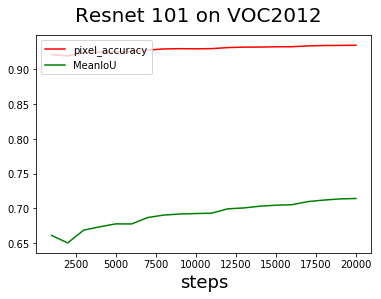

In [12]:
#I record the pixel acc and Mean iou by testing each saved model (1 model every 1000 steps).
pixel_acc = [0.9214271, 0.9194533, 0.92439073, 0.92480075, 0.9254558, 0.92576665, 0.9279742, 0.9295503, 0.92993826, 0.92971146, 0.93003064, 0.9314928, 0.932139, 0.93223643, 0.93265295, 0.93276554, 0.93389785, 0.93451416, 0.93463105, 0.93487877]                                                                                  

iou = [0.6609606, 0.65021455, 0.66864043, 0.6734204, 0.6776351, 0.6775613, 0.68682593, 0.69030726, 0.691834, 0.69249755, 0.6931414, 0.6993254, 0.7005876, 0.70311743, 0.7045229, 0.7052667, 0.70974565, 0.71192294, 0.71356064, 0.7141889]     

steps = np.arange(1000,21000,1000)
plt.plot(steps, acc,'r',label='pixel_accuracy')
plt.plot(steps, iou,'g',label='MeanIoU')
plt.suptitle('Resnet 101 on VOC2012', fontsize=20)
plt.legend(loc='upper left')
plt.xlabel('steps', fontsize=18)
plt.show()

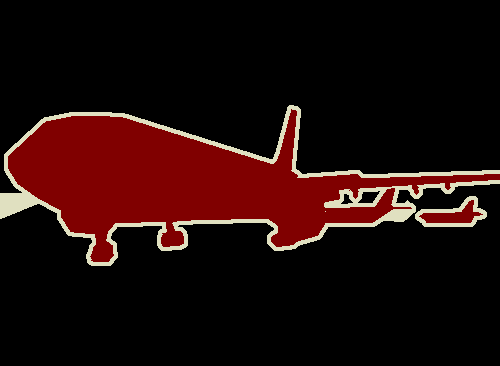

In [21]:
#display the ground truth
from PIL import Image
path = "img/2007_000033.png"
display(Image.open(path))

In [ ]:
#display the result from all 20 models (from steps 1000 to 20000)
from PIL import Image
for ckpt in np.arange(1000,21000,1000):
    path = "img/2007_000033_mask_visual"+str(ckpt)+".png"
    display(Image.open(path))